## Simple notebook to train a bear classifier using fastai. 

Note: to create data, images are downloaded with Bing Image Search. Sign up at Microsoft Azure for a free account and you will be given a key which you can copy and enter into the search function below (replace 'XXX' with your key before executing it).

## Step 1. Gather some image data

In [1]:
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

### Create a search function

In [2]:
def search_images_bing(key, search_term):
    subscription_key = key
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": "150"}
    
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    
    return search_results

### Test the search function
Remember to use your own key

In [48]:
import os
import requests
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [4]:
search_results = search_images_bing(key, 'grizzly bear')
img_urls = [img['contentUrl'] for img in search_results['value']]

In [5]:
len(img_urls)

150

In [6]:
#img_urls

In [7]:
img_urls[1]

'http://www.publicdomainpictures.net/pictures/90000/velka/grizzly-bear-profile.jpg'

In [8]:
dest = 'images/grizzly.jpg'
download_url(img_urls[1], dest)

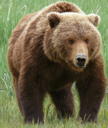

In [9]:
im = Image.open(dest)
im.to_thumb(128)

### Now pull down different types of bears

In [10]:
bear_types = 'grizzly','black','panda'
path = Path('bears')

In [11]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=[img['contentUrl'] for img in results['value']])

In [12]:
fns = get_image_files(path)
fns

(#348) [Path('bears/grizzly/00000047.jpg'),Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000107.jpg'),Path('bears/grizzly/00000036.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/grizzly/00000110.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000112.jpg')...]

### Remove any failed downloads

In [13]:
failed = verify_images(fns)
failed

(#0) []

In [14]:
failed.map(Path.unlink);

### Load and inspect the data

In [17]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128, min_scale=0.3))

In [18]:
dls = bears.dataloaders(path)

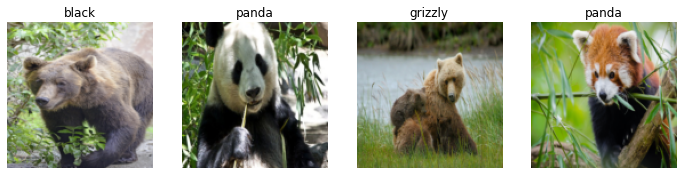

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

### Augment data

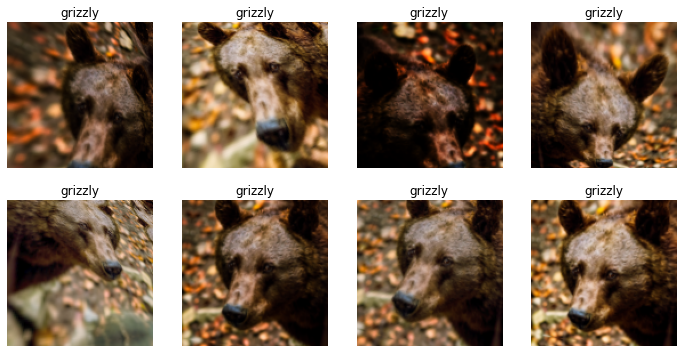

In [20]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Step 2. Train the model, and use it to clean the data

In [21]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.527936,1.591715,0.376812,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.604559,0.770898,0.275362,00:28
1,0.592230,0.475101,0.130435,00:27
2,0.500847,0.486995,0.173913,00:27
3,0.452007,0.501759,0.188406,00:27


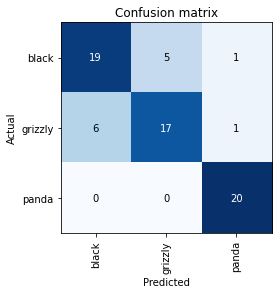

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

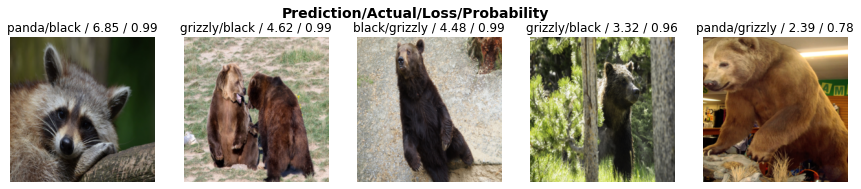

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Step 3. Export the model and test it

### Use the model for inference

In [43]:
learn.export()

In [44]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [45]:
learn_inf = load_learner(path/'export.pkl')

In [46]:
learn_inf.predict('images/grizzly.jpg')

('black', TensorImage(0), TensorImage([8.9645e-01, 1.0346e-01, 9.6446e-05]))

In [47]:
learn_inf.dls.vocab

['black', 'grizzly', 'panda']